# Further Topics with Maximum Likelihood

<font color='red'>Red text indicate discussion or investigation points</font>

<font color='blue'>Blue text indicates some exercises that could be attempted in a Colab notebook</font>


First we need to mount your drive directory and load some dependencies. Make sure your google drive system is configured


1) go to Shared with me directory

2) Right click on "Colab - Exp Meth. Hadron Spec " //note extra space at end

2) right click and go to "organise" then "add shortcut"

3) add shortcut to My Drive

We will now be able to access this directory in our Colab notebook from /content/drive/MyDrive/Colab - Exp Meth. Hadron Spec /


Now run the next cell to actually mount the drive. Note you will need to give permissions for Colab to access your google account.

In [1]:
# @title
## mount google drive so we can access other files
try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  #install weights pacakages
  !pip install iminuit
  !pip install sweights
  !pip install boost_histogram
  iscolab = True
except Exception:
  iscolab = False
  pass




Load some helper functions from another notebook Strong2020Utilities by running the following cell.

In [2]:
## load utilites script with helper functions etc
!pip install import-ipynb
import import_ipynb
if iscolab:
    source_path_file = '/content/drive/MyDrive/Colab - Exp Meth. Hadron Spec /FurtherMaximumLikelihood/Strong2020Utilities.ipynb'
    source_path_file = source_path_file.replace(' ', '\\ ')

    !cp $source_path_file '/content' # to copy the file from drive to colab
    !rsync -aP $source_path_file '/content/Strong2020Utilities.ipynb' # run this line to sync with the parent file in case you made any changes
    !ls
#else: assume we have a downloaded copy    
   
import Strong2020Utilities as s2020
s2020.about()
#!more /content/Strong2020Utilities.ipynb

loading .cshrc
importing Jupyter notebook from Strong2020Utilities.ipynb
Functions to help with Strong2020 Summer School tasks. 
 To use these functions you should prefix s2020. to the function call


In [3]:
print('Are we running on colab ',iscolab)

Are we running on colab  False


# Dealing with backgrounds

In [4]:
#store data in numpy arrays
import numpy as np
#use matplotlib for plotting
from matplotlib import pyplot as plt

## Toy Dataset

First we will import a simple toy data set for testing techniques on. This consists of 3 variables : mass, phi, and state. These will be loaded into 3 numpy arrays.
The data consists of signal and background events with different mass and phi distributions for each.

mass : Gaussian signal, log background distributions

phi : Photon Asymmetry distribution (1-h*Σ*cos(2ϕ)) with different values of Σ for signal and background

state : magnitude =1 for signal, 2 for background.
polarisation state, h = sign of state

In [5]:
#load data from file
if iscolab :
    dataArray = np.loadtxt('/content/drive/MyDrive/Colab - Exp Meth. Hadron Spec /Data Files/example.txt', usecols=range(3))
else:
    #!pip install gdown
    #import gdown
    #url = 'https://drive.google.com/file/d/15YnOFy_AE7hNBOQF4w3BRnRi2M3gYulY/view?usp=drive_link'
    exfile = 'example.txt'
    #gdown.download(url, exfile, quiet=False)
    dataArray = np.loadtxt(exfile, usecols=range(3))

print( "data file : ",dataArray )

#move data into arrays given by their names
mass = dataArray[:,0]
phi = dataArray[:,1]
state = dataArray[:,2]

#define mass range we want to use here, this can remove some background
mrange = (0.85,1.3)

#filter events on mass range
phi = phi[np.logical_and(mass > mrange[0], mass < mrange[1])]
state = state[np.logical_and(mass > mrange[0], mass < mrange[1])]
mass = mass[np.logical_and(mass > mrange[0], mass < mrange[1])]

print("phi ",phi,phi.size)
print("mass ",mass,mass.size)
print("state ",state,state.size)

data file :  [[ 1.18508   0.640313  1.      ]
 [ 1.01475   5.89936   2.      ]
 [ 0.983506  3.05945  -2.      ]
 ...
 [ 1.38359   6.13487  -2.      ]
 [ 1.36384   1.12189  -2.      ]
 [ 1.12189   2.59683  -2.      ]]
phi  [0.640313 5.89936  3.05945  ... 2.02081  4.4991   2.59683 ] 83156
mass  [1.18508  1.01475  0.983506 ... 1.24407  0.92379  1.12189 ] 83156
state  [ 1.  2. -2. ... -2.  2. -2.] 83156


Now we can plot each variable to see what we have. We will draw all, signal and background in different colours.

Note the histSqrtErrorBars is used to plot a histogram with error bars given by sqrt of the bin contents. This will not always be correct for the plots in this notebook.

First Mass


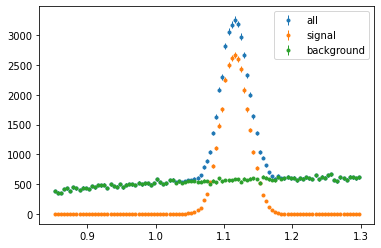

In [6]:
#define the binning, 100 bins in mrange
massbins = np.linspace(mrange[0],mrange[1], 100)
#call utility function histSqrtErrorBars to raw histograms with error bars
mass_hist = s2020.histSqrtErrorBars(mass, massbins, 'all')
sig_mass_hist = s2020.histSqrtErrorBars(mass[np.abs(state)==1], massbins, 'signal')
bg_mass_hist  = s2020.histSqrtErrorBars(mass[np.abs(state)==2], massbins, 'background')
plt.legend(loc='upper right')

Now phi

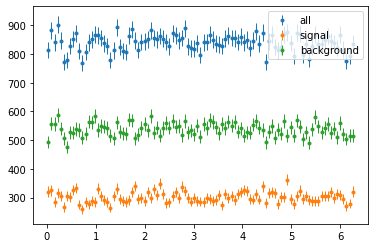

In [7]:
#define my binning for phi histograms, will use later
phibins = np.linspace(0, 2*np.pi, 100)

phi_hist = s2020.histSqrtErrorBars(phi, phibins, 'all')
sig_phi_hist = s2020.histSqrtErrorBars(phi[np.abs(state)==1], phibins, 'signal')
bg_phi_hist  = s2020.histSqrtErrorBars(phi[np.abs(state)==2], phibins, 'background')
plt.legend(loc='upper right')

The phi distributions were flat as we summed over polarisation state h. Lets select only +ve h, i.e. +ve state

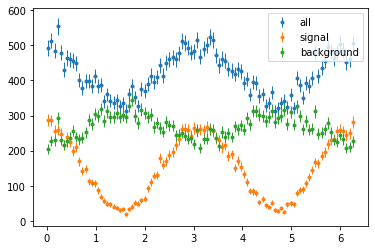

<Figure size 432x288 with 0 Axes>

In [8]:
para_phi_hist = s2020.histSqrtErrorBars(phi[state>0], phibins, 'all')
para_sig_phi_hist = s2020.histSqrtErrorBars(phi[state==1], phibins, 'signal')
para_bg_phi_hist  = s2020.histSqrtErrorBars(phi[state==2], phibins, 'background')
plt.legend(loc='upper right')
phi_fig=plt.figure()

Now we see we have cos2ϕ distributions with signal having a larger asymmetry and background having a different signed asymmetry.

## Extended Maximum Likelihood Fit of Signal ϕ distribution

Lets try some likelihood fits to see if we can estimate Σ for the signal. For simplicity we will assume only a single +ve polarisation state with degree of linear polarisation = 1.

(* Note normally we would see parallel or perpindicular polarisation states, but for ease of writing we use +ve and -ve labels instead.)

First we must define our PDF. This is just based on a photon asymmetry distribution as seen in earlier lectures.

$\frac{dσ(\phi:\Sigma)}{d\phi} = \sigma_{0}(1 - \Sigma \cos(2ϕ))$

As seen the normalisation integral for this functions is $\sigma_{0}/2\pi$. Hence our PDF,

$p(\phi:\Sigma) = \frac{1}{2\pi}(1 - \Sigma \cos(2ϕ))$

Although more generally I could have the phi fit range instead of $2\pi$.

In [9]:
#Photon Asymmetry PDF
def PhotonAsymmetryPDF(xphi,Sigma):
    return (1 - Sigma*np.cos(2*xphi))/2/np.pi

#Unormalised Photon Asymmetry
def PhotonAsymmetryN(xphi,Sigma,N):
  return N*PhotonAsymmetryPDF(xphi,Sigma)

#Unormalised Photon Asymmetry for extended maximum likelihood
def PhotonAsymmetryNExt(xphi,Sigma,N):
  return (N,N*PhotonAsymmetryPDF(xphi,Sigma))

And lets plot this on the signal data

In [10]:
#Filter +ve polarisation signal events
sig_pos_mass = mass[state==1]
sig_pos_phi = phi[state==1]

bg_pos_mass = mass[state==2]
bg_pos_phi = phi[state==2]

print('Number of +ve signal events in our data = ', sig_pos_phi.size)

Number of +ve signal events in our data =  14938


Now to estimate the height of the function for the histogram, I know I have approximaely 15,000 events and 100 bins. So average height = 150. So I might guess I can just multiply my function by 150. But if I am using the PDF I must also scale by the $2\pi$ factor.

Σ looks large and -ve so I will guess 0.7 for its value.

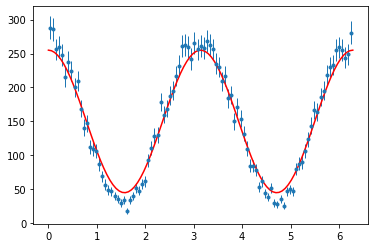

In [11]:
#plot +ve polarisation signal phi distribution
para_sig_phi_hist = s2020.histSqrtErrorBars(sig_pos_phi, phibins, 'signal')
#plot a photon asymmetry function with guess parameters N=150*2pi, Sigma = -0.7
plt.plot(phibins, PhotonAsymmetryN(phibins,-0.7,150*2*np.pi) , 'r-', label='first guess')

So the guess was reasonable. But lets find the best values using Maxmimum Likelihood.

I need to import minimisation classes. For these exercises we will use the iminuit package to perform a gradiant decent minimisation algorithm, migrad. Understanding this algorithm is very worthwhile, but not something we will cover here. Also there are other gradiant decent algothims available as well as completeley different methods such as genetic algorithms, or Bayesian methods such as MCMC or Nested Sampling which are also worth looking into for you own projects.

In [12]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit.cost import UnbinnedNLL

Now I need to give Minuit a function to minimise. This function is the negative log likelihood for my PDF summing over the data

$ \mathcal{L}(\theta_{j})=-\ln(L(\theta_{j}))  = - \sum_{k}^N \ln[p(x_{i,k}:\theta_{j})] = - \sum_{k}^N \ln[\frac{1}{2\pi}(1 - \Sigma \cos(2ϕ))]$

In [13]:
Ndata = sig_pos_phi.size

#mi = Minuit( ExtendedUnbinnedNLL(phi[state==1], PhotonAsymmetryN), sigma=-0.70, N = Ndata )
mi = Minuit( UnbinnedNLL(sig_pos_phi, PhotonAsymmetryPDF), Sigma=-0.70)

#set some physical limits on parameters

#mi.limits['N'] = (0,Ndata*1.1)
mi.limits['Sigma'] = (-1,1)


And then I can perform the migrad algorithm. Here I will also use the hesse method for better uncertainty estimation. <font color='red'>Students should make sure they understand both algorithms.

e.g. https://iminuit.readthedocs.io/en/stable/notebooks/hesse_and_minos.html

In [14]:
mi.migrad()
mi.hesse()

display(mi)

#save best estimate of Sigma to bestSigma
bestSigma=mi.values[0]
bestSigmaErr=mi.errors[0]
#Nminuit = mi.values[1]

print('Best value found for Sigma = ',bestSigma,'+-',bestSigmaErr)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.977e+04                  │              Nfcn = 19               │
│ EDM = 2.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.792   │   0.008   │            │            │   -1    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    Sigma │
├───────┼──────────┤
│ Sigma │ 6.63e-05 │
└───────┴──────────┘

Best value found for Sigma =  -0.7924352797328573 +- 0.008143530773786933


I should have got a value close to (within 1 or 2 standard deviations) of Σ = -0.8.

Note the displayed histrogram from iminuit does not attempt to give a very good comparison. You need to draw a new histogram with the result superimposed. As this was not an extended maximum likelihood fit, the normalisation was not determined. We must calculate this ourselves from the number of events (dividing by nbins and scaling by 2π).

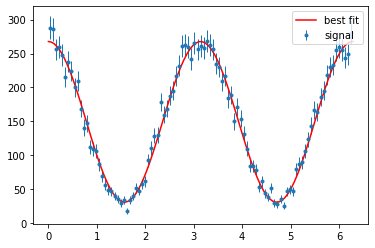

In [15]:
para_sig_phi_hist = s2020.histSqrtErrorBars(sig_pos_phi, phibins, 'signal')
plt.plot(phibins, PhotonAsymmetryN(phibins,bestSigma,Ndata/phibins.size*2*np.pi) , 'r-', label='best fit')
plt.legend(loc='upper right')

This looks good.

But the problem with data is I cannot normally seperate signal so easily. I need to use a discriminatory variable in some way. Next we will look at background subtractions via sPlots.

# Signal and Background fit to Mass distribution

In this example my discriminatory variable is going to be the mass distribution. This has distinct signal (Gaussian) and background (Unknown) components.

In [16]:
from scipy.stats import norm, expon, uniform
from numpy import polynomial

## Signal Distribution

To define my signal PDF I can start from scipy norm distribution. However remember the PDF normalisation integral must be calculated within the fit ranges. Therefore I only need the integral of the distribution within these bounds rather than -∞ to ∞

To get this I just use the difference of the Cumulative Density Function at the fit limits, which for the normal distribution is analytically known.

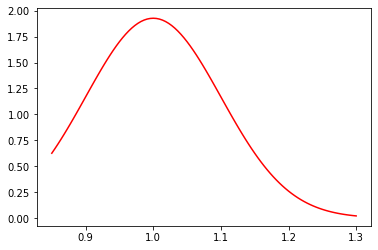

In [17]:
def SignalMassPDF(xmass,mean,width):
    sig  = norm(mean,width)
    #integral of signal function using CDF
    normInt = np.diff( sig.cdf(mrange) )/ (mrange[1]-mrange[0])
    #normalised PDF
    return sig.pdf(xmass)/normInt

#example PDF in fit range
plt.plot(massbins, SignalMassPDF(massbins,1,0.1) , 'r-', label='signal mass pdf')

Here we are going to use Extended Maximum Likelihood for our fits as it is required for the sPlot covariance matrix.

So I need to define a function for iminuit ExtendedUnbinnedNLL, which just multiplies the PDF by the yield

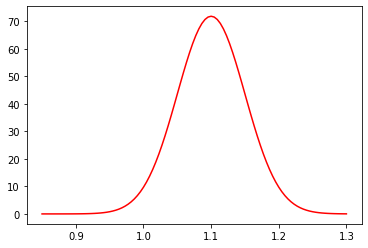

In [18]:
#Unnormalised function for extended maximum likelihood
#returns yield*PDF(mass)
def SignalMassNExt(xmass,mean,width,Ns):
  return (Ns,Ns*SignalMassPDF(xmass,mean,width))

#example plot
plt.plot(massbins, SignalMassNExt(massbins,1.1,0.05,2000)[1]/massbins.size , 'r-', label='extended mass function')

And do the fit with iminuit

In [19]:
Ndata = sig_pos_mass.size
#define iminuit extended unbinned -ve log likelihood minimisation
mi = Minuit( ExtendedUnbinnedNLL(sig_pos_mass, SignalMassNExt), mean=1.1,width=0.05, Ns=Ndata )
#Set Limits
mi.limits['Ns'] = (0,Ndata*1.1)
mi.limits['mean'] = (mrange[0],mrange[1])
mi.limits['width'] = (0.01,mrange[1]-mrange[0])
#Fit with migrad/hesse
mi.migrad()
mi.hesse()

display(mi)

#save values
bestMean=mi.values[0]
bestWidth=mi.values[1]

Nminuit = mi.values[2]

print('Best value for mean = ',bestMean,'+-',mi.errors[0])
print('Best value for width = ',bestWidth,'+-',mi.errors[1])
print('Best value for yield = ',Nminuit,'+-',mi.errors[2])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3.079e+05                 │              Nfcn = 84               │
│ EDM = 2.43e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  1.11560  │  0.00016  │            │            │  0.85   │   1.3   │       │
│ 1 │ width │ 20.02e-3  │  0.12e-3  │            │            │  0.01   │  0.45   │       │
│ 2 │ Ns    │  14.94e3  │  0.12e3   │            │            │    0    │ 16431.8 │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │     mean    width       Ns │
├───────┼────────────────────────────┤
│  mean │ 2.68e-08        0       -0 │
│ width │        0 1.34e-08       -0 │
│    Ns │       -0       -0 1.49e+04 │
└───────┴────────────────────────────┘

Best value for mean =  1.115599505696138 +- 0.0001638406396170522
Best value for width =  0.020024762538705436 +- 0.0001158527420533316
Best value for yield =  14938.189483459864 +- 122.21049038349156


I should get a mean around 1.1, width around 0.02 and a signal yield of around my number of data events ~ 15,000.

The iminuit plot may not always looks like a great fit, it is not meant to give a correct comparison. Best to redraw the function with the best values to check the fit.

 Note this time the normalisation has been determined by the extended fit and I just need to account for the number of bins in my histogram.

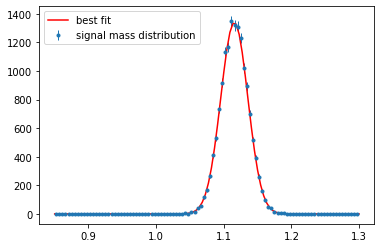

In [20]:
para_bg_mass_hist = s2020.histSqrtErrorBars(mass[state==1], massbins, 'signal mass distribution')
plt.plot(massbins, SignalMassNExt(massbins,bestMean,bestWidth,Nminuit)[1]/massbins.size , 'r-', label='best fit')
plt.legend(loc='upper left')

## Background Distribution

Often background distributions will not have a well defined PDF shape. As a proxy polynomial distributions can be used instead. This is likely to induce some systematic uncertainty in the final results due to mismodelling of the discriminatory variable fit, which should be investigated/estimated.

When fitting polynomials as PDFs it is often the Chebyshev form of the polynomials which is used. Here we will just use predefined functions for this.

<font color='red'>Students should investigate or discuss why Chebyshev's are better to use</font>

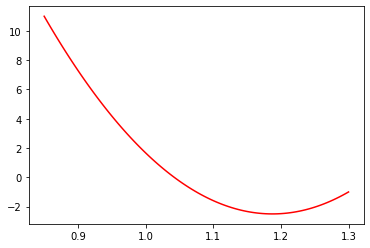

In [21]:
# define function to return value of chebyshev polynomial in x
# with coeffs =[c0,c1,c2,...] :
# c0*T0(x)+c1*T1(x)+...

def Cheb(x,coeffs):
  return np.polynomial.chebyshev.chebval(x,coeffs)

#for my PDF I am going to convert the range of my
#x variable to [-1,1] to use Chebyshev

#To calculate the normalisation integral I am going
#to numerically sum 100 values of cheb over the
# range [-1,1]. create sample point arrays
#masscentres = (massbins[:-1] + massbins[1:]) / 2
chebedges = np.arange(-1.0, 1.0, 1./1000)
chebcentres = (chebedges[:-1] + chebedges[1:]) / 2

def ChebPDF(x,coeffs):
    #transform x to 0 [-1,1]
    x = -1 + 2*(x-massbins[0])/(massbins[-1]-massbins[0])
    val  = Cheb(x,coeffs)
    #integral of function (approximate)
    integ = np.sum(Cheb(chebcentres,coeffs))/chebcentres.size
    #pdf value
    return val/integ

#test plot
coeffs = [0.2,-0.6,0.3]
plt.plot(massbins, ChebPDF(massbins,coeffs) , 'r-', label='signal mass pdf')

Now define my function for ExtendedUnbinnedNLL

In [22]:
##limit it to max 5 polynomial terms
def BgMassNExt(xmass,c0,c1,c2,c3,c4,Nb):
  return (Nb,Nb*ChebPDF(xmass,[c0,c1,c2,c3,c4]))

In [23]:
Ndata = bg_pos_mass.size
mi = Minuit( ExtendedUnbinnedNLL(bg_pos_mass, BgMassNExt), c0=1,c1=0,c2=0,c3=0, c4=0, Nb=Ndata )

mi.limits['Nb'] = (0,Ndata*1.1)
mi.limits['c0'] = (-1,1)
mi.limits['c1'] = (-1,1)
mi.limits['c2'] = (-1,1)
mi.limits['c3'] = (-1,1)
mi.limits['c4'] = (-1,1)

#fix overall normalisation coefficeint to 1
mi.fixed['c0'] = True
#Fix some coefficeints to 0 if I like
mi.fixed['c1'] = False
mi.fixed['c2'] = False
mi.fixed['c3'] = False
mi.fixed['c4'] = True

mi.migrad()
mi.hesse()

display(mi)

bg_c1=mi.values[0]
bg_c2=mi.values[1]
bg_c3=mi.values[2]
bg_c4=mi.values[3]
bg_c5=mi.values[4]
Nminuit = mi.values[5]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.882e+05                 │              Nfcn = 108              │
│ EDM = 2.15e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ c0   │   1.00    │   0.01    │            │            │   -1    │    1    │  yes  │
│ 1 │ c1   │   0.203   │   0.012   │            │            │   -1    │    1    │       │
│ 2 │ c2   │  -0.063   │   0.011   │            │            │   -1    │    1    │       │
│ 3 │ c3   │   0.016   │   0.010   │            │            │   -1    │    1    │       │
│ 4 │ c4   │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 5 │ Nb   │  26.55e3  │  0.16e3   │            │            │    0    │ 29208.3 │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       c0       c1       c2       c3       c4       Nb │
├────┼───────────────────────────────────────────────────────┤
│ c0 │        0        0        0        0        0        0 │
│ c1 │        0 0.000145  0.01e-3  0.06e-3        0       -0 │
│ c2 │        0  0.01e-3 0.000114  0.01e-3        0       -0 │
│ c3 │        0  0.06e-3  0.01e-3 0.000105        0       -0 │
│ c4 │        0        0        0        0        0        0 │
│ Nb │        0       -0       -0       -0        0 2.66e+04 │
└────┴───────────────────────────────────────────────────────┘

And draw the fit result with the data

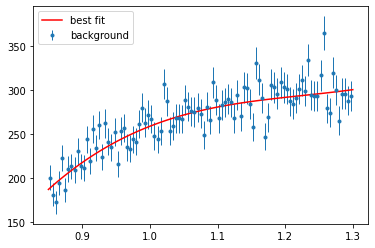

In [24]:
para_bg_mass_hist = s2020.histSqrtErrorBars(mass[state==2], massbins, 'background')
plt.plot(massbins, BgMassNExt(massbins,bg_c1,bg_c2,bg_c3,bg_c4,bg_c5,Nminuit)[1]/massbins.size , 'r-', label='best fit')
plt.legend(loc='upper left')

### Simulated Signal and Background PDFs
Aside : It is not always the case that a signal peak will be well fitted by a Gaussian distribution, or that a background can be easily constrained to a polynomial. In general simulations may give the best approximate PDF shapes for your event types.

<font color='red'> Practically how may you generate a PDF using simulated data ? What do you need and what might be the problems ?</font>

## Joint fit to 1D Signal and Background

We now have our signal and background PDF functions ($p_s$ and $p_b$) which we can use in Extended Maximim Likelihood fits. To proceed we must first combine this into a single distribution for fitting i.e.

$f(m:Y_s,Y_b,\mu_s,\sigma_s,c1_b,c2_b,c3_b,c4_b) = Y_s p_s(m:\mu_s,\sigma_s) + Y_b p_b(m:c1_b,c2_b,c3_b,c4_b)$

Where $Y_{s,b}$ are the expected signal and background yields in the data.
We then need to perform a full fit for all parameters $\theta_j = \{Y_s,Y_b,\mu_s,\sigma_s,c1_b,c2_b,c3_b,c4_b\}$

In [25]:
def CombinedMassNExt(xmass,smean,swidth,bc0,bc1,bc2,bc3,bc4,Ys,Yb):
  return ((Ys+Yb),Ys*SignalMassPDF(xmass,smean,swidth)+Yb*ChebPDF(xmass,[bc0,bc1,bc2,bc4,bc4]))

First make our combined data sets

In [26]:
#Filter all +ve polarisation events
pos_mass = mass[state>0]
pos_phi = phi[state>0]

print('Number of +ve  events in our data = ', pos_phi.size)

Number of +ve  events in our data =  41491


Now run minuit with ExtendedUnbinnedNLL on our combined PDF and dataset

In [27]:
Ndata = mass.size
mi = Minuit( ExtendedUnbinnedNLL(pos_mass, CombinedMassNExt), smean=bestMean, swidth=bestWidth,bc0=1,bc1=bg_c1,bc2=bg_c2,bc3=bg_c3, bc4=bg_c4, Ys=Ndata/2,Yb=Ndata/2 )
mi.limits['Yb'] = (0,Ndata*1.1)
mi.limits['Ys'] = (0,Ndata*1.1)
mi.limits['smean'] = (mrange[0],mrange[1])
mi.limits['swidth'] = (0.01,mrange[1]-mrange[0])
mi.limits['bc0'] = (-1,1)
mi.limits['bc1'] = (-1,1)
mi.limits['bc2'] = (-1,1)
mi.limits['bc3'] = (-1,1)
mi.limits['bc4'] = (-1,1)

#fix overall normalisation coefficeint to 1
mi.fixed['bc0'] = True
#Fix some coefficeints to 0 if I like
mi.fixed['bc1'] = False
mi.fixed['bc2'] = False
mi.fixed['bc3'] = False
mi.fixed['bc4'] = True

#do fitting
mi.migrad()

#save values
sg_mean=mi.values[0]
sg_width=mi.values[1]
bg_c1=mi.values[2]
bg_c2=mi.values[3]
bg_c3=mi.values[4]
bg_c4=mi.values[5]
bg_c5=mi.values[6]
Ysignal = mi.values[7]
Yback = mi.values[8]

display(mi)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -8.205e+05                 │              Nfcn = 166              │
│ EDM = 2.61e-07 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ smean  │  1.11569  │  0.00023  │            │            │  0.85   │   1.3   │       │
│ 1 │ swidth │ 19.93e-3  │  0.21e-3  │            │            │  0.01   │  0.45   │       │
│ 2 │ bc0    │   1.00    │   0.01    │            │            │   -1    │    1    │  yes  │
│ 3 │ bc1    │   0.204   │   0.011   │            │            │   -1    │    1    │       │
│ 4 │ bc2    │  -0.062   │   0.012   │            │            │   -1    │    1    │       │
│ 5 │ bc3    │   -0.1    │    1.5    │            │            │   -1    │    1    │       │
│ 6 │ bc4    │ 15.71e-3  │  0.16e-3  │            │            │   -1    │    1    │  yes  │
│ 7 │ Ys     │  14.81e3  │  0.17e3   │            │            │    0    │ 91471.6 │       │
│ 8 │ Yb     │  26.69e3  │  0.20e3   │            │            │    0    │ 91471.6 │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │        smean       swidth          bc0          bc1          bc2          bc3          bc4           Ys           Yb │
├────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  smean │     5.11e-08            0            0     -0.13e-6     -0.16e-6            0            0   -459.26e-6    114.49e-6 │
│ swidth │            0     4.63e-08            0     -0.23e-6      0.77e-6            0            0  14.66084e-3 -14.59971e-3 │
│    bc0 │            0            0            0            0            0            0            0            0            0 │
│    bc1 │     -0.13e-6     -0.23e-6            0     0.000125     -0.01e-3            0            0   -293.82e-3    185.53e-3 │
│    bc2 │     -0.16e-6      0.77e-6            0     -0.01e-3     0.000156            0            0    755.95e-3   -739.65e-3 │
│    bc3 │            0            0            0            0            0         1.99            0          0.0          0.0 │
│    bc4 │            0            0            0            0            0            0            0            0            0 │
│     Ys │   -459.26e-6  14.66084e-3            0   -293.82e-3    755.95e-3          0.0            0     2.91e+04     -0.013e6 │
│     Yb │    114.49e-6 -14.59971e-3            0    185.53e-3   -739.65e-3          0.0            0     -0.013e6     4.02e+04 │
└────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

And plot the fit result

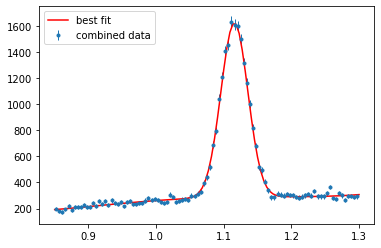

In [28]:
para_bg_mass_hist = s2020.histSqrtErrorBars(pos_mass, massbins, 'combined data')
plt.plot(massbins, CombinedMassNExt(massbins,sg_mean,sg_width,bg_c1,bg_c2,bg_c3,bg_c4,bg_c5,Ysignal,Yback)[1]/massbins.size , 'r-', label='best fit')
plt.legend(loc='upper left')

The fit should be pertty good although the polynomial background does not get such a good job close to threshold, if that is included in the range (Should be at 0.8). If the fit was succesfull then the results can now be used to generate weights for background subtraction (e.g. Sidebands or sPlots).

# sPlots


We are going to use the sweights library provided by https://sweights.readthedocs.io/en/latest/about.html
This is related to the referenced paper on Custom Orthogonal Weight functions, of which sPlots is a specific case of. https://www.sciencedirect.com/science/article/pii/S0168900222006076?via%3Dihub

One issue with sweights is it requires zero dependence between the discriminatory and physics variables used and this is often not the case. The COWS method suggests a solution for the case where there is a dependence, but it is beyond the scope of these lectures.

In our toy dataset the discrimiatory (mass) and physics(phi) variables are independent for both signal and background events.

In [29]:
from sweights import SWeight # for classic sweights

Remember the sWeights formula,


$   w_{t,k} = \frac{\sum_{t'}^{N_{t}} V_{tt'}.P_{t'}(x_{k}) }{\sum_{t'}^{N_{t}} Y_{t'}.P_{t'}(x_{k})}$

The SWeight() function will calculate the covariance matrix,

$ \left[ V_{tt'} \right]^{-1} = \frac{\partial ^2 \mathcal{ L}(\theta^{best}_{j},Y_{t})}{\partial Y_{t}Y_{t'}} = \sum^{N_{k}}_{k}\frac{P_{t}(x_{k})P_{t'}(x_{k})}{\left( \sum_{t'}^{N_{t}} Y_{t'}.P_{t'}(x_{k}) \right)^{2}}$

It can use either method, taking the approximate partial derivitives from a extended maximum likelihood fit, with method="roofit" $^{note}$ (left option) or by summing over the data events k with method="summation" (right option).

$note :$ This is indeed what RooFit does and the implementation just calls RooFit, however you need RooFit imported for that, which is not possible within Colab currently.

In [30]:
# create best value PDFs for signal and background
spdf = lambda m: SignalMassPDF(m,sg_mean,sg_width)
bpdf = lambda m: ChebPDF(m,[bg_c2,bg_c3,bg_c4,bg_c5])

# make the sweighter
# note here I am using the fits to the positive data
sweighter = SWeight( pos_mass, [spdf,bpdf], [Ysignal,Yback], (mrange,), method='summation', compnames=('sig','bkg'), verbose=True, checks=True )

Initialising sweight with the summation method:
    PDF normalisations:
	 0 0.4499999999999992
	 1 0.4498687600447206
    W-matrix:
	[[4.91384538e-05 1.02267413e-05]
	 [1.02267413e-05 3.17906752e-05]]
    A-matrix:
	[[21810.91026572 -7016.35105054]
	 [-7016.35105054 33712.85448948]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 9.99941794e-01 -3.81009290e-04]
	 [-3.70663726e-04  1.00062027e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        | 14805.5884 | 14805.5884 |    -0.00% |
	  1        | 26685.4393 | 26685.4393 |     0.00% |


Plot the weights

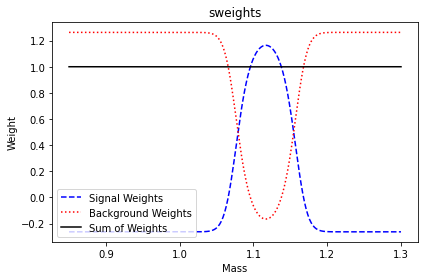

In [31]:
def plot_wts(x, sw, bw, title=None):
    fig,ax = plt.subplots()
    ax.plot(x, sw, 'b--', label='Signal Weights')
    ax.plot(x, bw, 'r:' , label='Background Weights')
    ax.plot(x, sw+bw, 'k-', label='Sum of Weights')
    ax.set_xlabel('Mass')
    ax.set_ylabel('Weight')
    if title: ax.set_title(title)
    fig.tight_layout()


# plot weights
xaxmass = np.linspace(*mrange,400)
swp = sweighter.get_weight(0,xaxmass)
bwp = sweighter.get_weight(1,xaxmass)
plot_wts(xaxmass, swp, bwp,"sweights")
plt.legend(loc='lower left')

<font color='red'>Students should discuss if these weights look reasonable. Why are Signal Weights <0 in some regions ? </font>


Now plot the weighted phi distributions for the +ve polarisation data

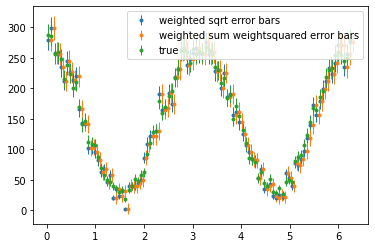

In [32]:
# Get signal only weights
sig_weights  = sweighter.get_weight(0, pos_mass)

fig, ax = plt.subplots()
para_phi_sig = s2020.histWeightsSqrtErrorBars(pos_phi, sig_weights, phibins, 'weighted sqrt error bars')
#draw offset sum squared weights errors
para_phi_sig = s2020.histWeightedErrorBars(pos_phi, sig_weights, phibins, 'weighted sum weightsquared error bars',0.05)
#draw true signal distribution
para_phi_sig_tru = s2020.histSqrtErrorBars(sig_pos_phi, phibins, 'true')
plt.legend(loc='upper right')


<font color='red'>Students should investigate or discuss if these distributions and error bars look OK. Which are the correct error bars for the weighted data, blue or orange ? Should weighted data have same, smaller or larger error bars than true signal events ?</font>

<font color='blue'>Exercise : Make phi plots for background distributions</font>

<font color='red'>Lets consider the full mass range in the data file (draw with the next cell). We have restricted it in our test data and fits so far. Why might we a) restrict the range ? b) use as large a range as we can ?</font>

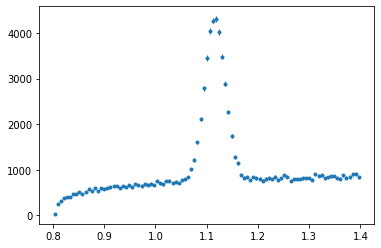

In [33]:
fullrange = np.linspace(0.8,1.4, 100)
mass_hist = s2020.histSqrtErrorBars(dataArray[:,0], fullrange, 'fullrange')


# Inclusion of Weights in Maximum Likelihood

We will again fit the Photon Asymmetry to extract Σ, but now we will disentangle the signal response using the sWeights in the fit.

Here we need to define our own loss function where the log likelihood values are weighted with our background subtraction weights.

The weighted negative log likelihood function,

$\mathcal{L}(\theta_{j}) = -  \sum_{k}^{N_{k}} w_{k} \ln[  p(x_{Pi,k}:\theta_{Pj})] = -  \sum_{k}^{N_{k}} w_{k} \ln[  p(\phi_{k}:\Sigma)]$

In [34]:
#NLL for maximum likelihood with weights
#Sigma = parameter to fit
#data_phi = array of phi data
#wk weights for signal (or background)
def PhotonAsymWeightedNLL(Sigma,data_phi,wk):
  pdf_vals=PhotonAsymmetryPDF(data_phi,Sigma)
  return (-np.sum( wk * np.log( pdf_vals ) ))


And perform the fit with iminuit

In [35]:
#create negative log likelihood function I can pass to iminuit
#nll = lambda s,N: PhotonAsymWeightedNLL(s,N,para_phi, sig_weights)
nll = lambda Sigma: PhotonAsymWeightedNLL(Sigma,pos_phi, sig_weights)

#create minuit fitter
mi = Minuit( nll, Sigma=0.1)
#mi.limits['N'] = (0,para_phi.size*1.1)
mi.limits['Sigma'] = (-1,1)

mi.migrad()
mi.hesse()


display(mi)

bestSigmaWgtd=mi.values[0]
print('best value for background subtracted Sigma = ',bestSigmaWgtd,'+-',mi.errors[0])

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.454e+04                  │              Nfcn = 24               │
│ EDM = 1.77e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.813   │   0.011   │            │            │   -1    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    Sigma │
├───────┼──────────┤
│ Sigma │ 0.000129 │
└───────┴──────────┘

best value for background subtracted Sigma =  -0.8128619781303481 +- 0.011355842446237052


<font color='red'>How do the results and uncertainties compare to the signal only fitting ? Does this seem reasonable ?</font>



In [36]:
print('best value for signal only data Sigma = ',bestSigma,'+-',bestSigmaErr)

best value for signal only data Sigma =  -0.7924352797328573 +- 0.008143530773786933


Now we can plot the fit result with the background subtracted data.

signal yield :  14805.588384960924


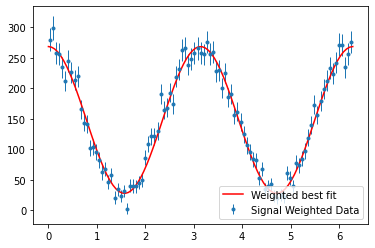

In [37]:
para_phi_sig = s2020.histWeightedErrorBars(pos_phi, sig_weights, phibins, 'Signal Weighted Data')
yld = np.sum(sig_weights) # get signal yield from sum of the weights
print('signal yield : ',yld)
plt.plot(phibins, PhotonAsymmetryN(phibins,bestSigmaWgtd,yld/phibins.size*2*np.pi) , 'r-', label='Weighted best fit')
plt.legend(loc='lower right')

## Uncertainties in Weighted Maximum Likelihood fits

In general correctly accounting for the effect of the weights on the uncertainties is a non-trivial task. For in-depth discussion of the asymptotically correct method see "Parameter uncertainties in weighted unbinned maximum likelihood fits", Langenbruch, https://epjc.epj.org/articles/epjc/abs/2022/05/10052_2022_Article_10254/10052_2022_Article_10254.html

We will test the simplest method given therein, which is not in general correct, but can give a good approximation. It has been used in many publications. That is to add an additional factor to the sum of logs in the likelihood,

$\mathcal{L}(\theta_{j}) = - \frac{\sum_{k}^{N_{k}} w_{k}}{\sum_{k}^{N_{k}} w_{k}^{2}} \sum_{k}^{N_{k}} w_{k} \ln[  p(x_{Pi,k}:\theta_{Pj})]$

You should see a similarity between this "sum of weights, over, sum of weights squared" factor and our histogram uncertainties.

In [38]:
#NLL for maximum likelihood with weights
#See Langenbruch (19)
def PhotonAsymWeightedW2WNLL(Sigma,data_phi,wk):
  pdf_vals=PhotonAsymmetryPDF(data_phi,Sigma)
  yld = np.sum(wk)
  sw2 = np.sum(wk*wk)
  #sum of weights/ sum of weights squared correction factor
  return (-(yld/sw2) * np.sum( wk * np.log( pdf_vals ) ))
  # + N - yld*np.log(N))

In [39]:
nllw2w = lambda Sigma: PhotonAsymWeightedW2WNLL(Sigma, pos_phi, sig_weights)
mi = Minuit( nllw2w, Sigma=0.1 )

mi.limits['Sigma'] = (-1,1)
mi.migrad()
mi.hesse()
display(mi)

print('best value for background subtracted Sigma with sumw2 correction = ',mi.values[0],'+-',mi.errors[0])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.666e+04                  │              Nfcn = 24               │
│ EDM = 1.2e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.813   │   0.014   │            │            │   -1    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────┐
│       │   Sigma │
├───────┼─────────┤
│ Sigma │ 0.00019 │
└───────┴─────────┘

best value for background subtracted Sigma with sumw2 correction =  -0.8128619781313945 +- 0.013782576438664651


# More Uncertainties : Bootstrapping

As outlined in the Langenbruch paper, Bootstrapping provides another independent method for estimating the uncertainties.

In the paper two variations are performed 1) Boot strap the data and use the same weights; 2) Bootstrap the data and redo the sPlot fits.

Here we will follow (1) with (2), the better method, left as an exercise.

Bootstrapping involves refitting the data many times. Each time using a different selection of events. Events are sampled from the original data set and crucially (to get correct variance) the sampling is done with replacements (i.e. 1 event is chosen from the same Nk events for each event in the bootstrapped data set).  The point estimates of the fit results can then be used to construct the standard deviation or confidence levels. Pretty simple, bruteforce, effective!

To achieve an accurate estimate of the uncertainty a large number O(10,000) of bootstrap samples should be fit.

<font color='red'>You can search the web to find more about bootstrapping for uncertainties, it is a common tool.</font>

Algorithm :

  * Sample $N_{k}$ events (or a fraction of) from the $N_{k}$ data events $N_{boot}$ times.
  * Each time refit the sampled data and save the result.

We have a couple of control parameters,
  
  Nboot =  The number of bootstrap fits to perform

  frac_to_sample =  The fraction of $N_{k}$ events to use in each new bootstrap data sample

## Bootstrap Signal Only Data

First we can validate the mothod using fits to signal only data, and check we get a consistent uncertainty as we did in "Extended Maximum Likelihood Fit of Signal ϕ distribution"

In [40]:
#data_phi_sig_para = phi[state==1]
Nk = sig_pos_phi.size

Nboot = 100
frac_to_sample = 1./1

#calc, number of events per bootstrap sample
#this could be = Nk
Nsamp = int(Nk*frac_to_sample)

#create list to save bootstrap results
bt_sigmas = []

#loop over Nboot samples
for bt in range(Nboot):
  #use random choice to do sampling with replacements
  phi_bt = np.random.choice(sig_pos_phi,Nsamp)

  #and do the fit for this bootstrap sample
  btmi = Minuit( UnbinnedNLL(phi_bt, PhotonAsymmetryPDF), Sigma=-0.5)
  btmi.limits['Sigma'] = (-1,1)
  btmi.migrad()
  #save results, only care about best fit value
  bt_sigmas.append(btmi.values[0])


[-0.7848729969433379, -0.79074754527971, -0.7919900244780621, -0.7777829284895585, -0.8032230826877693, -0.7880288731895455, -0.7876818089034331, -0.8002904913678213, -0.7947002982026096, -0.7984845464981625, -0.8017280398043046, -0.7944202803836632, -0.8083781130858653, -0.7937729917209904, -0.7925028878036593, -0.8034467816243642, -0.7918863948602304, -0.7835417032395381, -0.781206707997209, -0.799248334799331, -0.799197740831016, -0.8063697725587186, -0.7933109227061385, -0.799709132154042, -0.7998394423229472, -0.7911571527811209, -0.7892391359135905, -0.7900578190858359, -0.7888125082521442, -0.7883968052343847, -0.7875228828791164, -0.799676515175681, -0.7942960498887981, -0.8057033561614403, -0.7860849032178947, -0.7890388039080682, -0.7917979204304011, -0.797167563905834, -0.8021542695254553, -0.7673815018109215, -0.8004400366445517, -0.7999533368256957, -0.798047865816989, -0.7974079005196425, -0.8010116677589746, -0.7871310821842894, -0.784880612210268, -0.784398100488484, -0

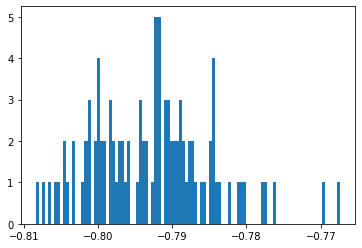

In [41]:
print(bt_sigmas)
plt.hist(bt_sigmas, bins=100 )
print('the mean of bootstrap samples = ',np.mean(bt_sigmas))
print('the standard deviation of bootstrap samples = ',np.std(bt_sigmas))
print('the scaled standard deviation of bootstrap samples = ',np.std(bt_sigmas)*np.sqrt(frac_to_sample))


<font color='red'>Why multiply the standard deviation by sqrt(frac_to_sample) ? </font>

<font color='blue'>Exercise : Complete the tables</font>

Best/mean value of  Σ from iminuit and bootstrapping.

Nboot / frac  | 1  | 1/4  | 1/16
--------------|----|------|-----------
iminuit       |    |  -   |-
10            |    |      |
100           |    |      |
1000          |    |      |
5000         |    |      |

Uncertainties on Σ from iminuit and bootstrapping.

Nboot / frac  | 1  | 1/4  | 1/16
--------------|----|------|-----------
iminuit       |    |  -   |-
10            |    |      |
100           |    |      |
1000          |    |      |
5000          |    |      |

## Bootstrap Background Subtracted Data



Now we want to try bootstrapping on the background subtracted fits to test our uncertaintiy estimates.

Algorithm :
  * Sample $N_{k}$ events (or a fraction of) from the $N_{k}$ data events $N_{boot}$ times.
  * Each time calculate the sPlot weights for the sampled data
  * Then refit the sampled data using weighted nll and save the result.

This is slower, so do not try too many boots.

In [42]:
#remember to get signal weights we use sig_weights  = sweighter.get_weight(0, para_mass)
#i.e. we are using the sweighter configured from the fit already done in "sPlots"

#remember data is pos_phi and pos_mass

Nk = pos_phi.size

Nboot = 100
frac_to_sample = 1./1
Nsamp = int(Nk*frac_to_sample)

bt_wgted_sigmas = []

#now we need to synchronise our bootstrap samples of mass and phi
#so we instead choose to sample the array indices
all_indices = np.arange(Nk)

for bt in range(Nboot):
  indices_bt = np.random.choice(all_indices,Nsamp)
  wgts_bt  = sweighter.get_weight(0, pos_mass[indices_bt])
  #now need to creaet nll
  btnll = lambda Sigma: PhotonAsymWeightedNLL(Sigma,pos_phi[indices_bt], wgts_bt)
  btmi = Minuit( btnll, Sigma=-0.1 )
  btmi.limits['Sigma'] = (-1,1)
  btmi.migrad()
  bt_wgted_sigmas.append(btmi.values[0])


[-0.8140650062500858, -0.8051379892244921, -0.8144594799124507, -0.8212844593670195, -0.8279113569100433, -0.8118223339366569, -0.7965678210289957, -0.8224305421664555, -0.8273221718954931, -0.810551489729066, -0.7971764044899735, -0.8417891735303416, -0.7873597234070092, -0.8202287266396024, -0.8234617544919142, -0.8010072790095383, -0.8045965502166773, -0.8191472523398505, -0.8134637315529609, -0.8000321741966109, -0.8021679294345491, -0.8001474528418572, -0.8298105187735609, -0.8126690996576964, -0.8310694771473327, -0.8181298576967616, -0.789117025805201, -0.7982523463061054, -0.8068966263389954, -0.830431588804129, -0.850020603478252, -0.8218254320251958, -0.8036661583006498, -0.8154200442402536, -0.8240208833003403, -0.8118487716078739, -0.7983173231382757, -0.8161976377216784, -0.8102136778602835, -0.8040154769182837, -0.8243840781511188, -0.8143758028952501, -0.8212801552345869, -0.8096749170631071, -0.8076092533300167, -0.826987687504309, -0.8114244583646884, -0.82640475697797

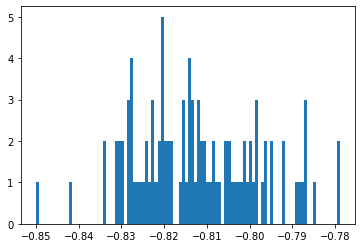

In [43]:
print(bt_wgted_sigmas)
plt.hist(bt_wgted_sigmas, bins=100 )
print('the mean of bootstrap samples = ',np.mean(bt_wgted_sigmas))
print('the standard deviation of bootstrap samples = ',np.std(bt_wgted_sigmas))
print('the scaled standard deviation of bootstrap samples = ',np.std(bt_wgted_sigmas)*np.sqrt(frac_to_sample))



<font color='blue'>Exercise : Complete the tables, using result from "Uncertainties in Weighted Maximum Likelihood fits</font>

Best/mean value of  Σ from weighted fits using iminuit and bootstrapping.

Nboot / frac  | 1  | 1/4  | 1/16
--------------|----|------|-----------
iminuit       |    |  -   |-
10            |    |      |
100           |    |      |
1000          |    |      |

Uncertainties on Σ from weighted fits using iminuit and bootstrapping. Give corrected (sum of weights over sum of weights squared) and uncorrected uncertainties for iminuit

Nboot / frac  | 1  | 1/4  | 1/16
--------------|----|------|-----------
iminuit uncor |    |  -   |-
iminuit cor   |    |  -   |-
10            |    |      |
100           |    |      |
1000          |    |      |


# Correcting for Acceptance

Acceptance refers to the probabilty of detecting and reconstructing your reaction at a given point in variable space $x_{i,k}={x_{0,k},x_{1,k},x_{2,k}...}$. The $x_{i,k}$ may be any measured (e.g momentum) or calculated variable (e.g. invariant mass). It can be given by the ratio of all events to those detected and reconstructed (aka accepted).

$η(x_{i,k}) = \frac{f_{acc}(x_{i,k})}{f_{all}(x_{i,k})} \approx \frac{N^{MC}_{acc}(x_{i,l})}{N^{MC}_{gen}(x_{i,l})}$

This acceptance is generally approximated through Monte-Carlo simulations of detector setups. To actually calculate a value for $η(x_{i,k})$ requires some integration of MC events $x_{i,l}$ sufficiently local to $x_{i,k}$. This can be problematic if $N_{i} > 2$, i.e. if we need an acceptance in high dimensions.

### Maximum Likelihood to the rescue!
In turns out, somewhat magically, the maximum likelihood method removes the need to determine $η(x_{i,k})$ for each event. It essentially just requires a single integration over full $x_{i,k}$ space. Now, in general, the integration needs to be done for every value of model parameters (used in the fitting) instead. This however can be done more accurately, than individual acceptances, for a given number of MC events.

Lets look at the equations. I have some function which describes my data that now depends on some physics model $I(x_{i}:\theta_{j})$ and some detector acceptance $\eta(x_{i})$,

$f(x_{i}:\theta_{j}) = I(x_{i}:\theta_{j}).\eta(x_{i})$

Then I can calculate my PDF using a numerical calculation of the normalisation integral which is a summation over all $M$ accepted MC simulation events.

$p(x_{i}:\theta_{j}) = \frac{I(x_{i}:\theta_{j})\eta(x_{i})}{ \sum^M_l I(x_{i,l}:\theta_{j})  }$

Note, η is not required in the summation as it is explicitly included in the accepted events $M$, which is less than the number of generated MC (or thrown) events.

$L(\theta_{j},Y) = \prod_{k=0}^N p(x_{i,k}:\theta_{j})$

$-\ln L(\theta_{j},Y)  = - \sum_{k=0}^N \ln[\frac{I(x_{i,k}:\theta_{j})}{ \sum^M_l I(x_{i,l}:\theta_{j})}] - \sum_k^N \ln{\eta(x_{i,k})} $

Now we observe the last term (summing logs of acceptance) does not depend on our model parameters $\theta_j$. Hence it is constant and can be ignored in the minimisation. The sum over $l$ MC events does depend on the parameters and so this must be recalculated for each parameter set in the minimisation.

## Toy Acceptance Model
The data we have used so far has been "perfectly" detected. to investigate acceptance effects we need to add in these to the data. To do this we will just define some simple ϕ dependent functions, with some degraded acceptance or holes.

In [44]:
#First a function to filter the data to mock up the acceptance
# darr = data array to be filtered
# condarr = data array with which to test the acceptance (does not have to be same as darr)
# acc_func = takes a data array and returns a probability of being accepted for each entry
def AcceptanceFilter(darr,condarr,acc_func):
    rands = np.random.uniform(0, 1, condarr.size)
    mask = rands[:] < acc_func(condarr)
    return darr[mask]

#An acceptance function with just a hole
def PhiAcceptHoleFunc(phi_vals):
  return (phi_vals >1) & (phi_vals <2)

# An acceptance function with a sin phi dependence
def PhiAcceptSinFunc(phi_vals):
  return (np.sin(0.5*phi_vals))

(array([  8.,  14.,  24.,  38.,  35.,  31.,  41.,  47.,  63.,  51.,  58.,
         47.,  54.,  47.,  46.,  35.,  42.,  35.,  30.,  27.,  24.,  17.,
         28.,  19.,  26.,  13.,  23.,  33.,  40.,  40.,  47.,  54.,  80.,
         94., 115., 111., 154., 139., 159., 167., 180., 202., 204., 251.,
        267., 265., 225., 242., 236., 281., 257., 248., 255., 248., 246.,
        243., 197., 208., 178., 179., 163., 156., 137., 137.,  95., 105.,
         65.,  70.,  58.,  41.,  56.,  27.,  35.,  36.,  22.,  22.,  21.,
         13.,  26.,  33.,  30.,  41.,  47.,  45.,  43.,  40.,  68.,  67.,
         61.,  59.,  68.,  57.,  53.,  39.,  42.,  32.,  29.,  18.,  14.,
          3.]),
 array([0.033715  , 0.09595965, 0.1582043 , 0.22044895, 0.2826936 ,
        0.34493825, 0.4071829 , 0.46942755, 0.5316722 , 0.59391685,
        0.6561615 , 0.71840615, 0.7806508 , 0.84289545, 0.9051401 ,
        0.96738475, 1.0296294 , 1.09187405, 1.1541187 , 1.21636335,
        1.278608  , 1.34085265, 1.4030973 , 1.

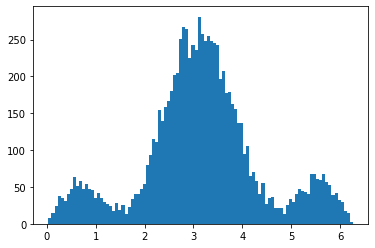

In [45]:
#again we will just use +ve polarisation signal data
acc_phi=AcceptanceFilter(sig_pos_phi,sig_pos_phi,PhiAcceptSinFunc)
#print(acc_phi,acc_phi.size)

plt.hist(acc_phi,bins=100)

Now lets try fitting the filtered data ignoring the acceptance.

In [46]:
mi = Minuit( UnbinnedNLL(acc_phi, PhotonAsymmetryPDF), Sigma=-0.5 )

mi.migrad()
mi.hesse()

display(mi)

meth0Sigma = mi.values[0]
meth0Error = mi.errors[0]
print('Best value found for Sigma = ',meth0Sigma,'+-',meth0Error)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.058e+04                  │              Nfcn = 26               │
│ EDM = 9.43e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.711   │   0.012   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    Sigma │
├───────┼──────────┤
│ Sigma │ 0.000144 │
└───────┴──────────┘

Best value found for Sigma =  -0.7111486665707035 +- 0.012020245829730606


This should probably be significantly removed from the true value of -0.8.
Also the plots do not match at all (allthough we should not take them too seriuosly)

Now lets try applying weights to correct for acceptance. This is different from the method discussed about, but since we can analyitically calculate the weights we might as well see how it does.

i.e. we are going to use a likelihood like,

$-\ln L(\theta_{j},Y)  = - \sum_{k=0}^N \ln[\frac{p(x_{i,k}:\theta_{j})\eta(x_{i,k})}{\eta(x_{i,k})}]$

In [47]:
#create acceptance weights
acc_wgts = PhiAcceptSinFunc(acc_phi)

nll = lambda Sigma: PhotonAsymWeightedNLL(Sigma, acc_phi, acc_wgts)
mi = Minuit( nll, Sigma=0.1 )
mi.limits['Sigma'] = (-1,1)

mi.migrad()
mi.hesse()

display(mi)

meth1Sigma = mi.values[0]
meth1Error = mi.errors[0]
print('Best value found for Sigma = ',meth1Sigma,'+-',meth1Error)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.244e+04                  │              Nfcn = 24               │
│ EDM = 6.9e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.786   │   0.017   │            │            │   -1    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    Sigma │
├───────┼──────────┤
│ Sigma │ 0.000272 │
└───────┴──────────┘

Best value found for Sigma =  -0.7860080913249142 +- 0.01649361400663918


This should give a value much closer to -0.8.

Now we can try our normalisation integral method.

For this we will define a new PDF for the Photon Asymmetry where we include the acceptance in the normalisation integral.

Here I am just calculating the function value at regular intervals along its range. To be more in line with using MC data I could have generated random points and used those instead.

<font color='blue'>Exercise : Try switching to random samples rather than regular arrays for the numeric integration.</font>

In [48]:
#include acceptance in normalisation integral

integral_edges = np.arange(0, 2*np.pi, 0.001)
integral_centres = (integral_edges[:-1] + integral_edges[1:]) / 2

def PhotonAsymAccPDF(xphi,Sigma):
    #evaluate PDF over samples
    vals  = PhotonAsymmetryPDF(integral_centres,Sigma)
    #evaluate acceptance function over samples
    accs  = PhiAcceptSinFunc(integral_centres)
    #sum to get integral
    integ = np.sum(vals*accs)/integral_centres.size
    #return value of PDF
    return PhotonAsymmetryPDF(xphi,Sigma)/integ

Now use this PDF with acceptance in normalisation integral in the likelihood fit.

In [49]:
mi = Minuit( UnbinnedNLL(acc_phi, PhotonAsymAccPDF), Sigma=0.1 )

mi.migrad()
mi.hesse()

display(mi)

meth2Sigma = mi.values[0]
meth2Error = mi.errors[0]
print('Best value found for Sigma = ',meth2Sigma,'+-',meth2Error)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.128e+04                 │              Nfcn = 31               │
│ EDM = 2.92e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Sigma │  -0.787   │   0.010   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────┐
│       │  Sigma │
├───────┼────────┤
│ Sigma │ 0.0001 │
└───────┴────────┘

Best value found for Sigma =  -0.7872391309901174 +- 0.010015710393314819


Hopefully the value has turned out to be close to -0.8 again! But the uncertainty is different from the previous example where we divided out the acceptance.

Of course we have learnt that we may use Bootstrapping to check the uncertainties from likelihood minimisations. Lets try that here.

To make it neater lets define a bootstrapper function which takes the data with acceptance and a -ve log likelihood function.

In [50]:
def bootstrapper(all_data,Nboot,frac, nll) :

  Nsamp = int(all_data.size*frac)

  bt_sigmas = []

  #bootstrap loop : sample, fit, store
  for bt in range(Nboot):
    phi_bt = np.random.choice(all_data,Nsamp)
    btmi = Minuit( nll(phi_bt), Sigma=0  )
    btmi.migrad()
    bt_sigmas.append(btmi.values[0])

  #output results
  plt.hist(bt_sigmas, bins=100 )
  print('\n the mean of bootstrap samples = ',np.mean(bt_sigmas))
  print('the standard deviation of bootstrap samples = ',np.std(bt_sigmas))
  print('the scaled standard deviation of bootstrap samples = ',np.std(bt_sigmas)*np.sqrt(frac))

  return bt_sigmas

Checking normalisation integral method
Remember best value found for Sigma =  -0.7872391309901174 +- 0.010015710393314819

 the mean of bootstrap samples =  -0.7820659407206674
the standard deviation of bootstrap samples =  0.04297225278350618
the scaled standard deviation of bootstrap samples =  0.010743063195876545


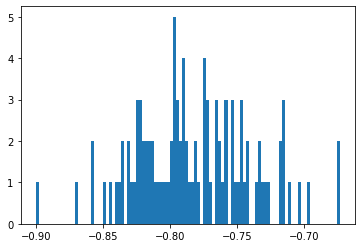

In [51]:
print('Checking normalisation integral method')
print('Remember best value found for Sigma = ',meth2Sigma,'+-',meth2Error)
#check normalisation integral method
unll = lambda evs: UnbinnedNLL(evs, PhotonAsymAccPDF)
sigs = bootstrapper(acc_phi,100,1./16,unll)

How does the bootstrap uncertainty compare to the iminuit one ?

# <font color='blue'>Further Exercises

<font color='blue'>0)Create weights for the data using a sideband method (see overview slides) and plot the sideband subtracted phi distributions. i.e. Redo the sPlots Section for sideband subtraction.

<font color='blue'>1)The data contain para and perp polarized data. Currently we have used just para.Write an expanded Photon Asymmetry function to include both polarisation states and fit the signal only data.

* Now try applying the acceptance function to filter the data. Try fitting without applying any acceptance correction, what do you think you will get as a result ?

<font color='blue'>2) For bootstrapping we do not reproduce the sWeights each fit. Should we ?
Include an sweight fit to the mass distributions of the bootstrap samples before the likelihood fit for the photon asymmetry

Algorithm :
  * Sample $N_{k}$ events (or a fraction of) from the $N_{k}$ data events $N_{boot}$ times.
  * Each time redo the sPlot Extended Maximum Likelihood fit and create new sweighter
  * Then calculate the sPlot weights for the sampled data
  * Finally, refit the sampled data using weighted nll, new weights and save the result.

3) Rather than subtracting background we may perform a simultaneous fit to both signal and background distributions dependent on the discriminatory variable and control variable, i.e. mass and phi. Deduce the combined PDF function and try fitting the data with it. How do the results compare, which should be more reliable ?</font>

